<a href="https://colab.research.google.com/github/mertcanozcelik/Taxonomy/blob/main/Taksonomi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **REHBER**

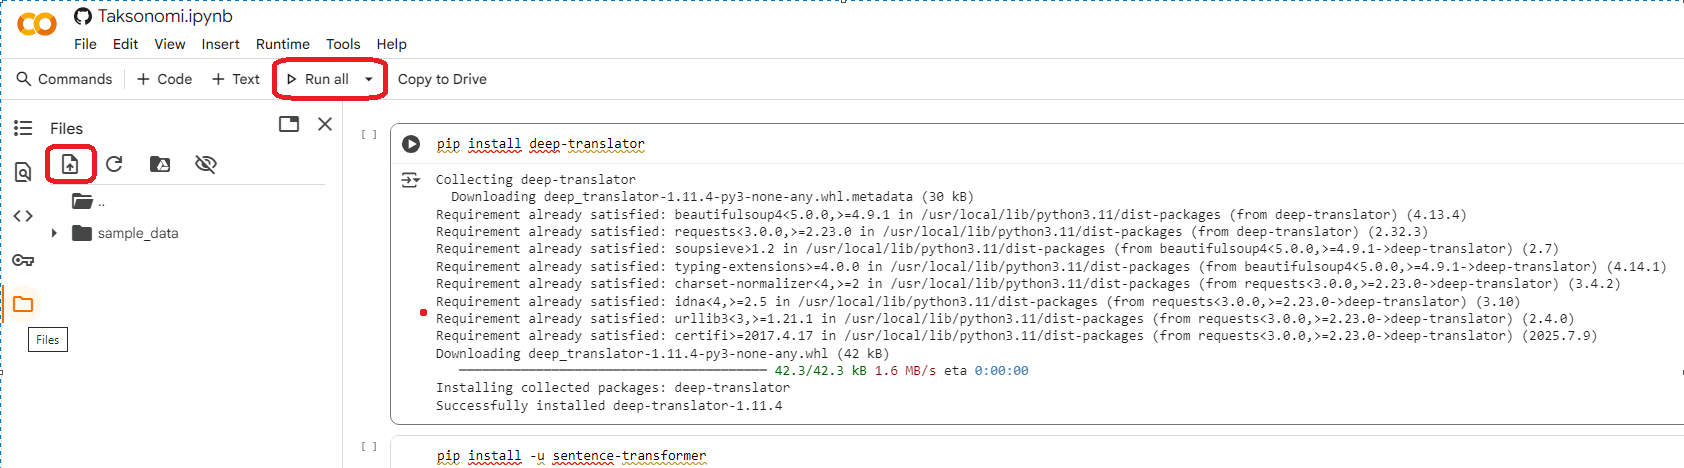

Files kısmından **\\vds\is_amacli_gecici_paylasim_yetki_kontrollu\Mertcan** adresinde yer alan dokümanlar yüklendikten sonra Run All denilerek sorgu işlemi başlatılır. Sorgu excelinde Açıklamalar sütunu altında ilgili sorgulara eklendikten sonra sorgu işlemi başlatılmalıdır.



In [ ]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip install -u sentence-transformer


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
# Değişiklik 1: Kütüphane değiştirildi
from deep_translator import GoogleTranslator
from tqdm import tqdm

# --- AYARLAR ---
# Bu bölümde bir değişiklik yapmanıza gerek yok.
SOURCE_DATA_FILE = "ssb_teknoloji_taksonomisi.xlsx"
QUERY_FILE_PATH = "sorgu.xlsx"
QUERY_COLUMN_NAME = "Açıklamalar"
OUTPUT_FILE_PATH = "arama_sonuclari_revize.xlsx"
TOP_N_RESULTS = 3
# --- KOD BAŞLANGICI ---

def initialize_model_and_data():
    """Modeli ve kaynak veriyi yükleyip ön-işler."""
    print("Model yükleniyor (Bu işlem biraz zaman alabilir)...")
    model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
    print("Model yüklendi.")

    print(f"Kaynak veri seti ({SOURCE_DATA_FILE}) okunuyor...")
    df = pd.read_excel(SOURCE_DATA_FILE)

    codes = df.iloc[:, 0].astype(str).tolist()
    titles = df.iloc[:, 1].astype(str).tolist()
    paragraphs_to_compare = df.iloc[:, 2].astype(str).tolist()
    paragraphs_to_display = df.iloc[:, 3].astype(str).tolist()

    print("Kaynak veri setindeki paragraflar için embedding oluşturuluyor...")
    paragraph_embeddings = model.encode(
        paragraphs_to_compare, convert_to_tensor=True, show_progress_bar=True
    )
    print("Embedding oluşturma tamamlandı.")

    return model, paragraph_embeddings, codes, titles, paragraphs_to_display

# Değişiklik 2: Fonksiyon parametresi güncellendi (artık translator nesnesine gerek yok)
def find_similar_documents(query_sentence, model, embeddings, top_k):
    """Verilen bir sorgu cümlesine en çok benzeyen belgeleri bulur."""
    try:
        # Değişiklik 3: Çeviri işlemi deep-translator ile yapılıyor
        # Bu kütüphane doğrudan metni döndürür ve 'await' gerektirmez.
        input_sentence_en = GoogleTranslator(source='auto', target='en').translate(query_sentence)
        if not input_sentence_en: # Çeviri sonucu boş veya None ise
            raise ValueError("Çeviri başarısız oldu.")

    except Exception as e:
        print(f"Çeviri hatası: '{query_sentence}' sorgusu atlanıyor. Hata: {e}")
        return []

    input_embedding = model.encode(input_sentence_en, convert_to_tensor=True)
    similarities = util.pytorch_cos_sim(input_embedding, embeddings)[0]

    combined_similarities = []
    for i in range(len(similarities)):
        combined_similarities.append((similarities[i].item(), i))

    combined_similarities.sort(key=lambda x: x[0], reverse=True)

    return combined_similarities[:top_k]

def main():
    """Ana işlem akışını yürüten fonksiyon."""
    model, paragraph_embeddings, codes, titles, paragraphs_to_display = initialize_model_and_data()

    print(f"Sorgu dosyası okunuyor: {QUERY_FILE_PATH}")
    try:
        query_df = pd.read_excel(QUERY_FILE_PATH)
        if QUERY_COLUMN_NAME not in query_df.columns:
            print(f"HATA: '{QUERY_COLUMN_NAME}' sütunu '{QUERY_FILE_PATH}' dosyasında bulunamadı.")
            return
    except FileNotFoundError:
        print(f"HATA: '{QUERY_FILE_PATH}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
        return

    queries = query_df[QUERY_COLUMN_NAME].dropna().tolist()
    print(f"Toplam {len(queries)} adet sorgu işlenecek.")

    all_results_data = []

    for query in tqdm(queries, desc="Sorgular işleniyor"):
        # Değişiklik 4: Fonksiyon çağrısı güncellendi
        top_results_indices = find_similar_documents(
            query, model, paragraph_embeddings, TOP_N_RESULTS
        )

        if not top_results_indices:
            all_results_data.append({
                "Orjinal Sorgu": query,
                "Sıra": 1,
                "Benzerlik": "HATA",
                "Bulunan Kod": "İşlenemedi",
                "Bulunan Başlık": "İşlenemedi",
                "Bulunan Açıklama (TR)": "Bu sorgu çevrilirken veya işlenirken bir hata oluştu."
            })
            continue

        for rank, (score, index) in enumerate(top_results_indices, 1):
            all_results_data.append({
                "Orjinal Sorgu": query,
                "Sıra": rank,
                "Benzerlik": round(score, 3),
                "Bulunan Kod": codes[index],
                "Bulunan Başlık": titles[index],
                "Bulunan Açıklama (TR)": paragraphs_to_display[index],
            })

    print("Tüm sorgular işlendi. Sonuçlar Excel dosyasına yazılıyor...")

    results_df = pd.DataFrame(all_results_data)
    results_df.to_excel(OUTPUT_FILE_PATH, index=False, engine='openpyxl')

    print(f"İşlem tamamlandı! Sonuçlar '{OUTPUT_FILE_PATH}' dosyasına kaydedildi.")


if __name__ == "__main__":
    main()


Model yükleniyor (Bu işlem biraz zaman alabilir)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]